In [13]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms

In [14]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii.
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star

    return a_stellar_radii

In [15]:
TIC = 'TIC 181949561' #WASP-39b / TIC 181949561

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))

lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 181949561" SECTOR=51 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [16]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2692.9591837111434,1.0026319e+00,2.5027478e-03,5.7287840e-03,1055159,618.38498,866.25181,4.0393496e+03,1.0060067e+01,2.7287864e+03,4.5851231e+00,4.6408438e+03,1.1584373e+01,0,———,———,———,———,618.38498,1.9717452e-03,866.25181,1.9793832e-03,-5.8685638e-02,8.0632448e-02
2692.9605726003288,1.0003240e+00,2.5057544e-03,5.7287849e-03,1055160,618.37992,866.24697,4.0317229e+03,1.0072153e+01,2.7424441e+03,4.5912933e+00,4.6301611e+03,1.1598289e+01,0,———,———,———,———,618.37992,1.9755657e-03,866.24697,1.9882147e-03,-5.8915585e-02,7.4570499e-02
2692.961961489049,1.0007342e+00,2.5062345e-03,5.7287854e-03,1055161,618.38252,866.25050,4.0331528e+03,1.0074082e+01,2.7415742e+03,4.5966668e+00,4.6320601e+03,1.1600512e+01,0,———,———,———,———,618.38252,1.9735647e-03,866.25050,1.9861213e-03,-5.7727616e-02,7.9196885e-02
2692.963350378234,1.0020903e+00,2.5092242e-03,5.7287863e-03,1055162,618.38306,866.25022,4.0376621e+03,1.0086101e+01,2.7576370e+03,4.6068540e+00,4.6383369e+03,1.1614350e+01,0,———,———,———,———,618.38306,1.9762428e-03,866.25022,1.9861609e-03,-6.0848914e-02,8.0616929e-02
2692.9647392669526,9.9770105e-01,2.5077639e-03,5.7287868e-03,1055163,618.38317,866.23965,4.0219282e+03,1.0080231e+01,2.7603035e+03,4.6031342e+00,4.6180205e+03,1.1607591e+01,0,———,———,———,———,618.38317,1.9806640e-03,866.23965,1.9930343e-03,-5.6578293e-02,6.6806413e-02
2692.966128155673,9.9928004e-01,2.5095625e-03,5.7287873e-03,1055164,618.38177,866.24794,4.0263508e+03,1.0087461e+01,2.7621360e+03,4.6097593e+00,4.6253291e+03,1.1615915e+01,0,———,———,———,———,618.38177,1.9833539e-03,866.24794,1.9938273e-03,-5.6851361e-02,8.0369838e-02
2692.967517044858,1.0025119e+00,2.5126385e-03,5.7287882e-03,1055165,618.38355,866.24473,4.0399487e+03,1.0099825e+01,2.7700913e+03,4.6116090e+00,4.6402881e+03,1.1630154e+01,0,———,———,———,———,618.38355,1.9784779e-03,866.24473,1.9910871e-03,-5.9547819e-02,7.5338073e-02
2692.9689059335783,1.0024220e+00,2.5153474e-03,5.7287887e-03,1055166,618.37949,866.25323,4.0393611e+03,1.0110714e+01,2.7775029e+03,4.6197209e+00,4.6398721e+03,1.1642693e+01,0,———,———,———,———,618.37949,1.9808933e-03,866.25323,1.9902526e-03,-6.2744863e-02,8.5587136e-02


In [17]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

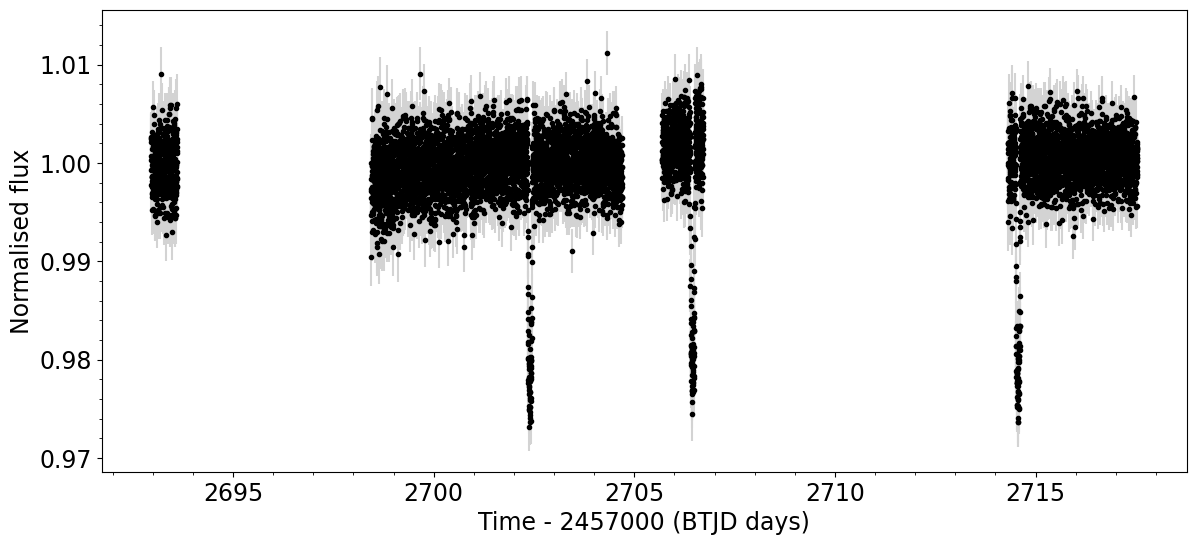

In [18]:
fig, ax = plt.subplots(1, figsize=(14,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [19]:
prior_Rs = 0.939 #R_sun, Mancini et al. 2018

guess_params = batman.TransitParams()
guess_params.ecc = 0 #Fixed to 0; Ricci et al. 2015
guess_params.w = 90
guess_params.limb_dark = "quadratic"
guess_params.u = [0.35092681757927346, 0.22991353177818383] #Estimated from WASP_39b_ldc.ipynb

In [20]:
def set_params(params, guess_flux, yerrs):
    """
    Creating a GaussianProcess object for a Matern32Term kernel. 

    Parameters
    ----------
    params : array_like
        Containing Matern32Term kernel parameters.
        _sigma, _rho = params 
    
    guess_flux : array_like
        Containing the physical (batman) model flux.
    
    yerrs : array_like
        Containing an array of flux errors from TESS observations.

    Returns
    -------
    gp : GaussianProcess
        GaussianProcess object.

    """
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=guess_flux)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

In [21]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    #Physical model
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis, _sigma, _rho = prior_params

    guess_params.t0 = t_0
    guess_params.rp = R_planet_stellar
    guess_params.per = orbital_period
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis
    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)

    #Systemic model
    kernel_params = [_sigma, _rho]
    gp = set_params(kernel_params, guess_flux, yerrs)

    prob = gp.log_likelihood(true_flux)
    return prob



def log_prior(prior_params):
    """
    Log prior

    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis, _sigma, _rho = prior_params

    prob = 0.0

    #Physical constriants
    if (t_0 < 2702.0) or (t_0 > 2703.0): #Days
        return -np.inf

    if (R_planet_stellar < 0.130) or (R_planet_stellar > 0.155):
        return -np.inf

    if (orbital_period < 3.9) or (orbital_period > 4.1): #Days
        return -np.inf

    if (orbital_inclination < 82) or (orbital_inclination > 90): #Degrees
        return -np.inf
    
    if (semi_major_axis < 10) or (semi_major_axis > 15): #AU
        return -np.inf
    
    #Systematic constriants
    if _sigma < 0 or _sigma > 0.1:
        return -np.inf
    
    if _rho < 0 or _rho > 500:
        return -np.inf

    return prob

def log_prob(prior_params, true_flux, yerrs):
    """
    Log probability of the prior parameter given the evidence (i.e observed flux data).

    Parameters
    ----------
    prior_params : array_like
        prior_t0, prior_rprs, prior_per, prior_inc, prior_a, _sigma, _rho = prior_params
    
    true_flux : array_like
        TESS flux data. 
    
    yerrs : array_like
        Containing an array of flux errors from TESS observations.

    Returns
    -------
    probability : float
        The log probability


    """

    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, true_flux, yerrs) + lp

In [22]:
prior_t0 = 2702.3 #Myself
prior_rprs = 0.1457 #Maciejewski et al. 2016
prior_per = 4.05527999 #(Days) Fischer et al. 2016
prior_inc = 87.93 #(Deg) 4.Fischer et al. 2016
prior_a = semi_major_axis_in_stellar_radii(0.04858, prior_Rs) #(AU) Maciejewski et al. 2016
_sigma = 0.0005 #Myself
_rho = 1 #Myself

guess = [prior_t0, prior_rprs, prior_per, prior_inc, prior_a, _sigma, _rho]

In [23]:
scatter = 1E-8 #Walker scattering of the parameters

pos = guess + scatter * np.random.randn(20, len(guess))

nwalkers, ndim = pos.shape

filename = "WASP_39b.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    start_time = time.time()
    print("Start:       {}".format(time.ctime(int(start_time))))
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(flux_data, yerrs), a=2)
    sampler.run_mcmc(pos, 100000, progress=True)
    
    end_time = time.time()
    execution_time = (end_time - start_time)
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

Start:       Sun Feb 12 14:21:09 2023


100%|██████████| 100000/100000 [59:09<00:00, 28.17it/s] 

End:         Sun Feb 12 15:20:19 2023
Time taken:  3549.71 s


In [24]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [1810.82950183 9313.65942394 4495.95610177 5155.50984683 4724.57024573
 1662.04901957 7311.38568551]

In [25]:
burnin = int(5 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples.shape)

NameError: name 'tau' is not defined

In [26]:
filename = "WASP_39b_flat_samples.p"
file = open(filename, "wb")
pickle.dump(flat_samples, file)
file.close()

NameError: name 'flat_samples' is not defined

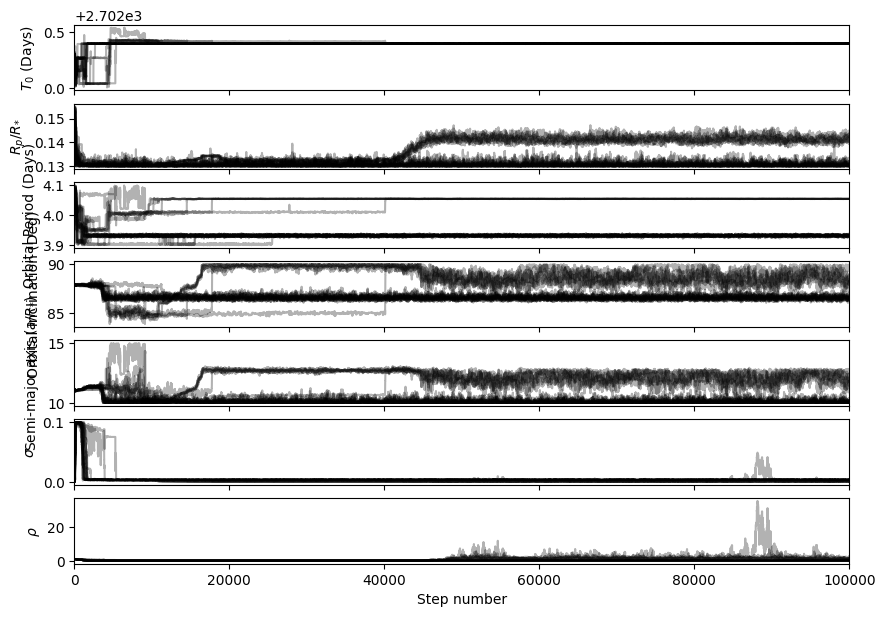

In [28]:
fig, axes = plt.subplots(len(guess), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$T_{0}$ (Days)", "$R_{p}/R_{*}$", "Orbital Period (Days)", "Orbital Inclination (Deg)", "Semi-major axis ($a/R_{*}$)", "$\\sigma$", "$\\rho$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    # ax.axvline(x=burnin, color='red', ls="--",alpha=0.7)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step number")
plt.show()

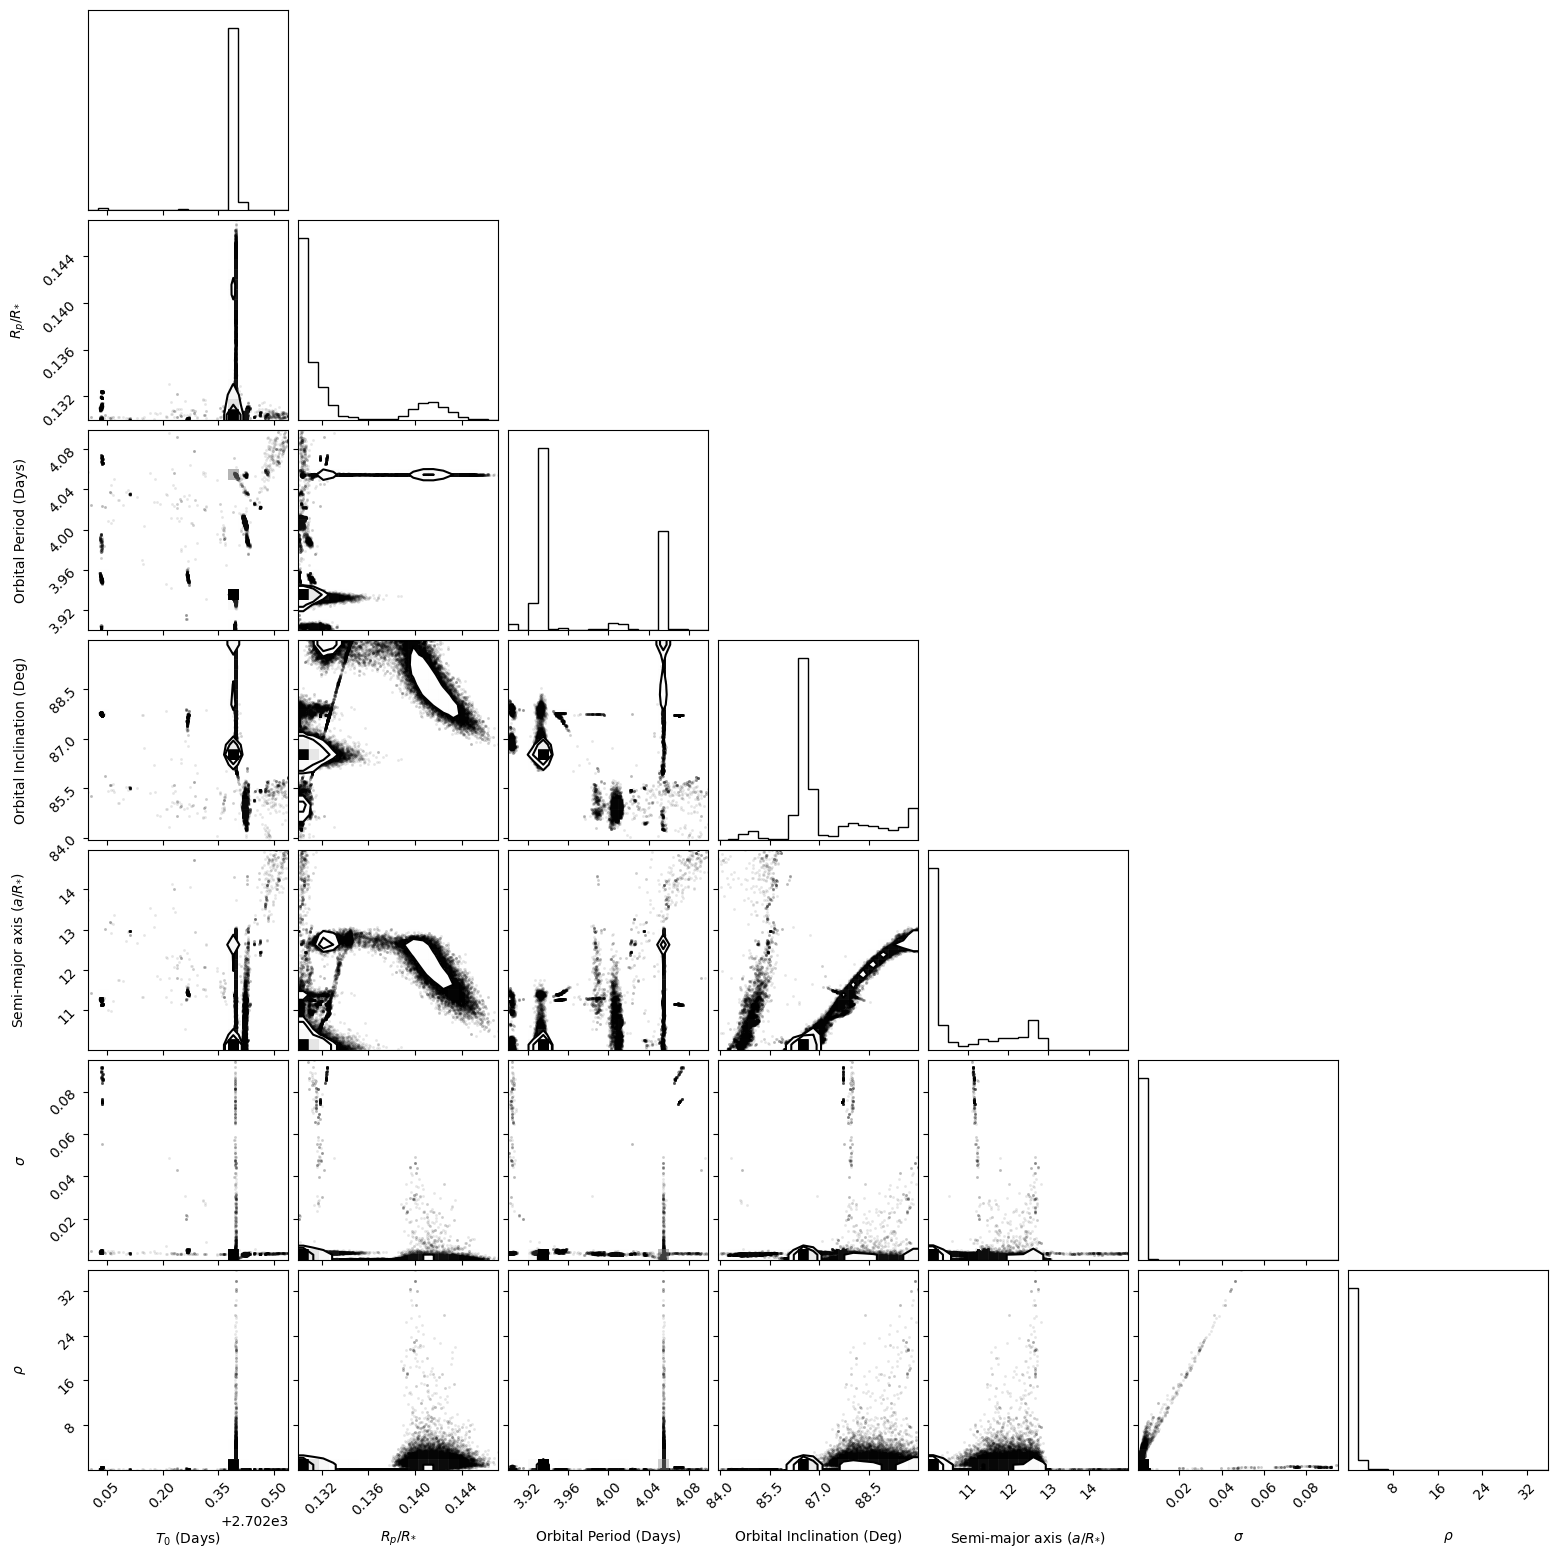

In [30]:
flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
fig = corner.corner(
    flat_samples, labels=labels)

In [31]:
transit_params = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.8f}_{{-{1:.10f}}}^{{{2:.10f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])

    val = "{}+{}-{}".format(mcmc[1], q[0], q[1])
    entry = [labels[i], val]
    transit_params.append(entry)

    display(Math(txt))

df = pd.DataFrame(data=transit_params)

df.to_csv("WASP_39b_params.csv",header=False, index=False)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>